In [20]:
import matplotlib.pylab as plt
import IPython.display as ipd 
import os
import json
import sys
sys.path.append('src/model')
sys.path.insert(0, './hifigan')
import numpy as np
import torch
import soundfile as sf
from pathlib import Path

from src.hparams import create_hparams
from src.training_module import TrainingModule
from src.utilities.text import text_to_sequence, phonetise_text
from hifigan.env import AttrDict
from hifigan.models import Generator
from nltk import word_tokenize
%matplotlib inline

import IPython.display as ipd
from src.utilities.mel_utilities import audio2mel, plot_mel, griffin_lim, load_wav_to_torch

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
#to plot spectogram 
def plot_spectrogram_to_numpy(spectrogram):
    fig, ax = plt.subplots(figsize=(12, 3))
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",
                   interpolation='none')
    plt.colorbar(im, ax=ax)
    plt.xlabel("Frames")
    plt.ylabel("Channels")
    plt.title("Synthesised Mel-Spectrogram")
    fig.canvas.draw()
    plt.show()
    
def plot_hidden_states(hidden_states):
    plt.plot(hidden_states_travelled)
    plt.xlabel("Time steps")
    plt.ylabel("HMM states")
    plt.title("Hidden states vs Time")
    plt.show()

def load_checkpoint(filepath, device):
    print(filepath)
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict    

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def load_checkpoint(filepath, device):
    print(filepath)
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict  

### Record voice and display melspectrogram

Use the link to record audio: https://voice-recorder-online.com/


In [23]:
ljspeech = "audio.wav"
ipd.Audio(ljspeech)

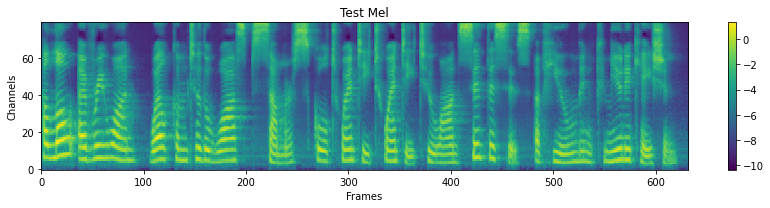

In [24]:
#load your audio file
filename = "audio.wav"
mel = audio2mel(filename)
plot_mel(mel, title="Test Mel")

### Load HiFi GANs

In [6]:
hifigan_loc = 'hifigan/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config_file = hifigan_loc + 'config.json'
hifi_checkpoint_file = hifigan_loc + 'generator_v1'
with open(config_file) as f:
    data = f.read()
json_config = json.loads(data)

h = AttrDict(json_config)
torch.manual_seed(h.seed)
generator = Generator(h).to(device)
state_dict_g = load_checkpoint(hifi_checkpoint_file, device)
generator.load_state_dict(state_dict_g['generator'])
generator.eval()
generator.remove_weight_norm()

hifigan/generator_v1
Loading 'hifigan/generator_v1'
Complete.
Removing weight norm...


### Copy synthesis LJ Speech

In [17]:
ljspeech = "audio.wav"
ipd.Audio(ljspeech)

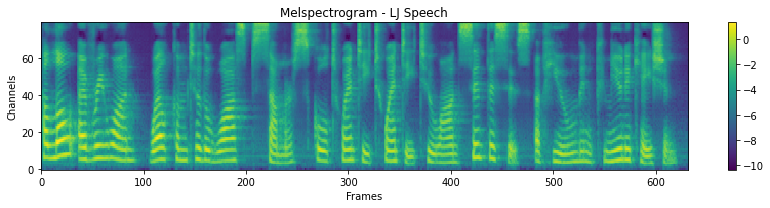

**************************************************

Copy synthesis using Griffin-Lim



**************************************************

Copy synthesis using  HiFi-GAN LJ Speech



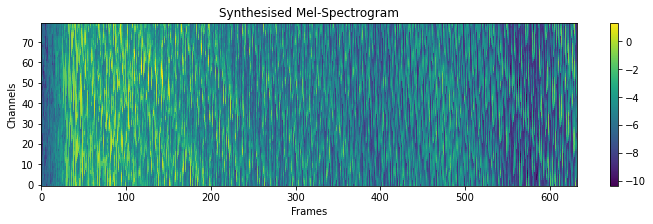

**************************************************



**************************************************



In [25]:
#display melspectrogram
mel = audio2mel(ljspeech)
plot_mel(mel, title="Melspectrogram - LJ Speech")
print(f"{''.join(['*'] * 50)}\n")

#copy synthesis using griffin lim
print('Copy synthesis using Griffin-Lim\n')
synthesis1_gl, sr = griffin_lim(ljspeech)
ipd.display(ipd.Audio(synthesis1_gl, rate=sr))
print(f"{''.join(['*'] * 50)}\n")

#copy synthesis using HiFi-GAN LJ Speech
print('Copy synthesis using  HiFi-GAN LJ Speech\n')
mel_outputs = torch.reshape(mel,(mel.shape[1],mel.shape[0])).unsqueeze(0).tolist()
for mel_output in mel_outputs:
    plot_spectrogram_to_numpy(np.array(mel_output).T)
with torch.no_grad():
    audios = []
    for i, mel_output in enumerate(mel_outputs):
        mel_output = torch.tensor(mel_output).T.unsqueeze(0).cuda().float()
        audio = generator(mel_output)
        audios.append(audio)
        ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=22050))
print(f"{''.join(['*'] * 50)}\n")

#copy synthesis using HiFi-GAN universal
mel_output = mel.unsqueeze(0).cuda().float()
audio = generator(mel_output)
ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=22050))
print(f"{''.join(['*'] * 50)}\n")

In [ ]:
1, 192, 80

1, 80, 192

In [9]:
mel_outputs = torch.reshape(mel,(mel.shape[1],mel.shape[0])).unsqueeze(0)
mel.shape

torch.Size([80, 632])

### Tacotron 2

In [10]:
#load tacotron2
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

#load waveglow
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

Using cache found in /workspace/.home/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/workspace/.home/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
Using cache found in /workspace/.home/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0): WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (1): Conv1d(51

In [11]:
text = "Hello world, I missed you so much."
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')
sequences, lengths = utils.prepare_input_sequence([text])

Using cache found in /workspace/.home/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


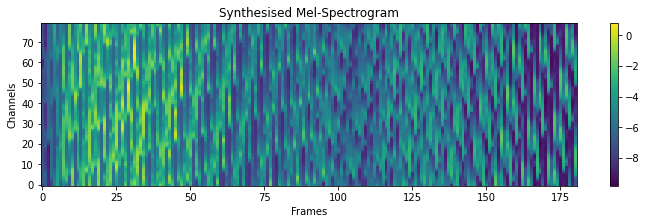

In [12]:
with torch.no_grad():
    mel, _, _ = tacotron2.infer(sequences, lengths)
    audio = waveglow.infer(mel)
mel_outputs=torch.reshape(mel,(mel.shape[0],mel.shape[2],mel.shape[1])).tolist() 
#mel_outputs = mel
for mel_output in mel_outputs:
    plot_spectrogram_to_numpy(np.array(mel_output).T)

audio_numpy = audio[0].data.cpu().numpy()
rate = 22050
ipd.display(ipd.Audio(audio_numpy, rate=rate))

In [30]:
mel.shape

torch.Size([1, 80, 199])

### Neural-HMM

In [12]:
#Set path variables for the checkpoints
checkpoint_path = "Neural-HMM.ckpt"


#Load pre-trained Neural HMM model trained on LJ Speech dataset 
model = TrainingModule.load_from_checkpoint(checkpoint_path)
_ = model.to(device).eval().half()

#Setup hparams
hparams = create_hparams()
model.model.hmm.hparams.max_sampling_time = 1800
model.model.hmm.hparams.duration_quantile_threshold=0.42
model.model.hmm.hparams.deterministic_transition=True
model.model.hmm.hparams.predict_means=True
model.model.hmm.hparams.prenet_dropout_while_eval=True

### Text preprocessing

In [13]:
texts= ["Hello Everyone! Welcome to WASP Summer school twenty twenty two on sythesis of human communication"]

sequences = []

for i, text in enumerate(texts):
    print(f"\n{''.join(['*'] * 20)}\n{i + 1} - Input text: \n{''.join(['*'] * 20)}\n{text}")
    text = phonetise_text(hparams.cmu_phonetiser, text, word_tokenize)
    print(f"\n{''.join(['*'] * 20)}\n{i + 1} - Phonetised text: \n{''.join(['*'] * 20)}\n{text}")
    sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
    sequence = torch.from_numpy(sequence).to(device).long()
    sequences.append(sequence)
    
    print(''.join(['='] * 100))


********************
1 - Input text: 
********************
Hello Everyone! Welcome to WASP Summer school twenty twenty two on sythesis of human communication

********************
1 - Phonetised text: 
********************
{HH AH0 L OW1} {EH1 V R IY0 W AH2 N} ! {W EH1 L K AH0 M} {T UW1} {W AA1 S P} {S AH1 M ER0} {S K UW1 L} {T W EH1 N T IY0} {T W EH1 N T IY0} {T UW1} {AA1 N} sythesis {AH1 V} {HH Y UW1 M AH0 N} {K AH0 M Y UW2 N AH0 K EY1 SH AH0 N}


### Mel Spectrogram

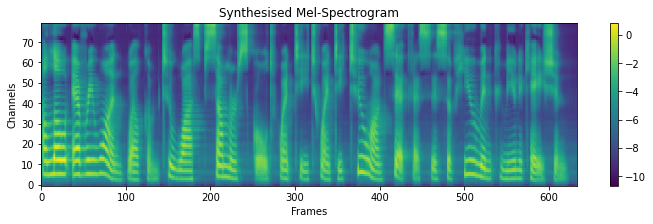

In [14]:
with torch.no_grad():
    mel_outputs, hidden_state_travelled_all = [], []
    for sequence in sequences:
        mel_output, hidden_state_travelled = model.inference(sequence)
        mel_outputs.append(mel_output)
        hidden_state_travelled_all.append(hidden_state_travelled)

for mel_output in mel_outputs:
    plot_spectrogram_to_numpy(np.array(mel_output).T)

### Mel-to-WAV using HiFi-GAN

In [33]:
with torch.no_grad():
    audios = []
    for i, mel_output in enumerate(mel_outputs):
        mel_output = torch.tensor(mel_output).T.unsqueeze(0).cuda().float()
        audio = generator(mel_output)
        audios.append(audio)
        print(f"{''.join(['*'] * 10)} \t{i + 1}\t {''.join(['*'] * 10)}")
        print(f"Text: {texts[i]}")
        ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate))
        print(f"{''.join(['*'] * 35)}\n")


********** 	1	 **********
Text: Hello Everyone! Welcome to WASP Summer school twenty twenty two on sythesis of human communication


***********************************



### Save to wav files using soundfile

In [ ]:
basepath = Path('synthesised_wavs')
basepath.mkdir(parents=True, exist_ok=True)

for i, audio in enumerate(audios):
    filename = basepath / f'syn_{i + 1}.wav'
    sr = 22500
    sf.write(filename, audio.data.squeeze().cpu().numpy(), 
             22500, 'PCM_24')
    print(f'Successfully written: {filename}')
